# new reference sky brightness for BGS
**problem**: the current reference/nominal sky brightness that is used to match SNR and calculate the exposure time is set to the nominal dark sky. As BGS requires short exposure times, using the nominal dark sky makes the exposure time calculation more complicated: read noise has a significant contribution to the dark sky noise, so it has to be included. 

**solution**: If we replace the reference sky brightness to one that is better reflects a BGS exposure, the exposure times can be calculated the sky ratios. In this notebook, I will calculate the new reference BGS sky brightness by combining: 
* nominal dark sky scaled to $r=21.07$
* moon/solar spectrum scaled to $r=20.07$

This will produce a reference sky brightness that is $\sim 3.5\times$ brighter than dark time, which should be more representative of bright time exposurse. This reference sky brightness is based on discussions with David Schlegel, David Kirkby, and Mike Wilson

In [1]:
import numpy as np 
import astropy.units as u
import matplotlib.pyplot as plt

import desisim.simexp
import specsim.instrument
from desimodel.io import load_throughput

In [2]:
# load configuration with specified wavelengths
wavemin = load_throughput('b').wavemin - 10.0
wavemax = load_throughput('z').wavemax + 10.0
wave = np.arange(round(wavemin, 1), wavemax, 0.8) * u.Angstrom

config = desisim.simexp._specsim_config_for_wave(wave.to(u.Angstrom).value, dwave_out=0.8, specsim_config_file='desi')

In [3]:
# get nominal dark sky 
sb_dict     = config.load_table(config.atmosphere.sky, 'surface_brightness', as_dict=True)
Isky_dark   = sb_dict['dark']

In [4]:
# get moon spectrum
moon_config = getattr(config.atmosphere, 'moon', None)
moon_flux = config.load_table(moon_config, 'flux')

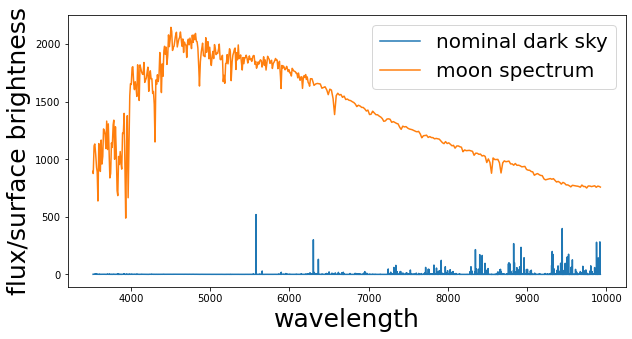

In [5]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.plot(wave, Isky_dark.value, label='nominal dark sky')
sub.plot(wave, moon_flux.value, label='moon spectrum')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_ylabel('flux/surface brightness', fontsize=25)
sub.legend(loc='upper right', fontsize=20)

In [6]:
from speclite import filters

def flux_to_mag(flux):
    return 22.5 - 2.5*np.log10(flux*10**9)

def get_mag(wsky, _Isky, band='r'): 
    ''' get magnitude of sky surface brightness
    '''
    Isky = _Isky * 1e-17 # erg/s/cm^2/A/(sq. arcsec?)
    filter_response = filters.load_filter('decam2014-{}'.format(band))
    moon_flux, sky_wlen = filter_response.pad_spectrum(Isky, wsky)
    sky_brightness = filter_response.get_ab_maggies(moon_flux, sky_wlen)
    return flux_to_mag(sky_brightness)

# scale nominal dark sky to $r=21.07$

In [7]:
# nominal dark sky r-band mag
r_mag_nom = get_mag(
    wave, # Ang
    Isky_dark.value # 1e-17 erg/s/cm^2/A/arcsec^2
)
print('nominal dark sky r-band mag/arcsec^2 = %f' % r_mag_nom)

nominal dark sky r-band mag/arcsec^2 = 20.590579


In [8]:
f_nom_scale = (10**((22.5 - r_mag_nom) / -2.5))/ (10**((22.5 - 21.07) / -2.5))

In [9]:
print(get_mag(wave, Isky_dark.value * f_nom_scale))

21.07


# scale moon spectrum to $r = 20.07$

In [10]:
# r-band magnitude of moon spectrum. Since we renormalize it,
# we don't care about the fact its flux not surface brightness and etc.
r_mag_moon = get_mag(
    wave, # Ang
    moon_flux.value # 1e-17 erg/s/cm^2/A/arcsec^2
)

In [11]:
f_moon_scale = (10**((22.5 - r_mag_moon) / -2.5))/ (10**((22.5 - 20.07) / -2.5))

In [12]:
print(get_mag(wave, moon_flux.value * f_moon_scale))

20.07


# New BGS reference sky brightness

In [13]:
Iref = Isky_dark.value * f_nom_scale + moon_flux.value * f_moon_scale

In [14]:
print(get_mag(wave, Iref))

19.706131243755884


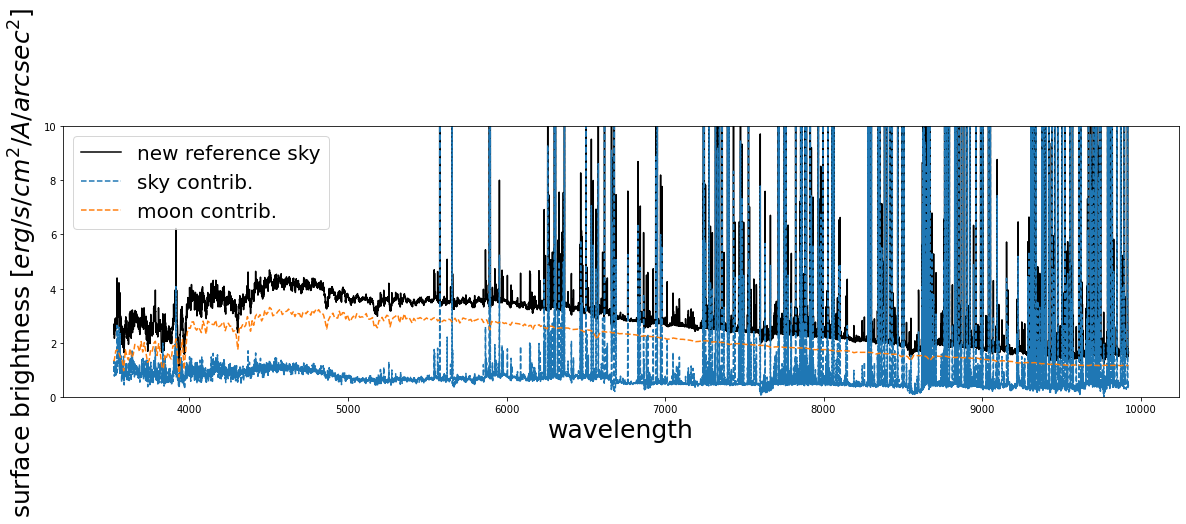

In [15]:
fig = plt.figure(figsize=(20,5))
sub = fig.add_subplot(111)
sub.plot(wave, Iref, c='k', label='new reference sky')
sub.plot(wave, Isky_dark.value * f_nom_scale, ls='--', label='sky contrib.')
sub.plot(wave, moon_flux.value * f_moon_scale, ls='--', label='moon contrib.')
sub.set_xlabel('wavelength', fontsize=25)
sub.set_ylabel('surface brightness [$erg/s/cm^2/A/arcsec^2$]', fontsize=25)
sub.set_ylim(0., 10.)
sub.legend(loc='upper left', fontsize=20)

# save reference sky brightness to file

In [16]:
f_reference = '/global/cfs/cdirs/desi/users/chahah/BGS_reference_sky_brightness.20210210.npy'
np.save(f_reference, np.array([wave, Iref]))